In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from itertools import product

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import mode

I pulled and cleaned a comprehensive dataset of colleges from this governmental database:
    
https://collegescorecard.ed.gov/data/

Let's read this dataset in:

In [2]:
df = pd.read_csv('data/schools.csv', index_col = 0)
print(df.shape)
df.head()

(6740, 46)


,name,ownership,ope6_id,state,size,accreditor,retention,branches,online_only,religious_affil,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,Alaska Bible College,2,8843,AK,27,Association for Bibical Higher Educaiton,0.333300,1,0,88.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,Alaska Christian College,2,41386,AK,68,Association for Bibical Higher Educaiton,0.473700,1,0,37.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,Ilisagvik College,1,34613,AK,109,Northwest Commission on Colleges and Universities,0.809500,1,0,-2.0,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,Charter College-Anchorage,3,25769,AK,3256,Accrediting Council for Independent Colleges a...,0.703723,1,0,-2.0,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,Alaska Career College,3,25410,AK,479,Accrediting Commission of Career Schools and C...,0.794100,1,0,-2.0,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


We are going to use classification algorithms to try to predict for-profit or non-profit status. 

Some of the categories aren't applicable to what we want to do so let's consider the following columns only:


In [3]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]
X.head()

,size,retention,branches,online_only,under_investigation,most_common_degree,highest_degree,faculty_salary,instructional_expenditure_per_fte,tuition_revenue_per_fte,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,27,0.333300,1,0,0,3,3,2201,9585,8132,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,68,0.473700,1,0,0,1,2,5554,18174,12989,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,109,0.809500,1,0,0,1,2,6054,38265,3587,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,3256,0.703723,1,0,0,1,3,4004,2617,8755,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,479,0.794100,1,0,0,1,2,3861,4178,11905,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


Let's first use a method called [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to see which features have the most statistically significant relationships with profit status. The **lower** the p value, the **more** statistically significant:

In [4]:
y = X.pop('for_profit')

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('chi2-value', 'feature')
features

chi2-value feature


[(0.0, 'avg_family_income'),
 (0.0, 'branches'),
 (0.0, 'faculty_salary'),
 (0.0, 'instructional_expenditure_per_fte'),
 (0.0, 'loan_principal'),
 (0.0, 'pell_grant_debt'),
 (0.0, 'size'),
 (0.0, 'tuition_revenue_per_fte'),
 (5.339096890496358e-283, 'highest_degree'),
 (2.3550018048916394e-222, 'most_common_degree'),
 (5.4025502611485345e-149, 'fac_salary_listed_y_n'),
 (8.240679129762035e-148, 'relig_y_n'),
 (5.293172158552389e-143, 'age_entry'),
 (1.4125160311604572e-48, 'percent_dependent'),
 (1.429381130658807e-24, '5_year_declining_balance'),
 (1.3527931483014932e-21, 'federal_loan_rate'),
 (6.095800240149601e-17, 'percent_black'),
 (3.249757484508949e-15, 'fafsa_sent'),
 (2.3099399670292976e-10, '7_yr_repayment_completion'),
 (5.332261659651546e-09, 'first_generation'),
 (1.4079344574521532e-08, 'part_time_share'),
 (1.51637032044754e-08, 'dep_low_income'),
 (5.389960032435694e-08, 'percent_pell_grant'),
 (2.9423628117769607e-06, 'students_with_any_loans'),
 (9.035892891499908e-0

1.Based on the info above, what was intuitive? What was surprising? How big (or small) of an effect does accredition have on for-profit status? What might be some guesses as to why this is the case?

In [ ]:
#insert

2.Do a test/train split and give the testing accuracy error for logistic regression.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.30, random_state=4444)

model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8981206726013847

3.Find the optimal number of nearest neighbors for KNN using grid search and then give the test accuracy. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.30, random_state=4444)

model = KNeighborsClassifier(n_neighbors = 9)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8936696340257171

4.Run a classification report and describe in detail what the terms mean in the context of your model.

In [13]:
classification_report(y_test, model.predict(X_test)).split('\n')

['              precision    recall  f1-score   support',
 '',
 '           0       0.91      0.90      0.91      1144',
 '           1       0.87      0.89      0.88       878',
 '',
 '   micro avg       0.89      0.89      0.89      2022',
 '   macro avg       0.89      0.89      0.89      2022',
 'weighted avg       0.89      0.89      0.89      2022',
 '']

5.Print a confusion matrix and describe what it means in your context.

In [14]:
confusion_matrix(y_test, model.predict(X_test))

array([[1027,  117],
       [  98,  780]])

6.Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, and KNN classifiers.

In [15]:
def my_classifier(X,y,estimator, best_param, fig, ax):
    
    pipeline = [('scaler', StandardScaler())]
    
    if estimator == 'logistic':
        pipeline.append( ('estimator',  LogisticRegressionCV(Cs=10, cv=5, random_state=1)))
    
    elif estimator == 'naive_bayes':
        pipeline.append(('estimator',  naive_bayes.GaussianNB()))
    
    elif estimator == 'k_nearest_neighbors':
        pipeline.append(('estimator',  KNeighborsClassifier(n_neighbors = 9)))
    elif estimator == 'decision_tree':
        pipeline.append(('estimator', DecisionTreeClassifier()))            
    elif estimator == 'SVM':
        pipeline.append(('estimator', svm.SVC(kernel='rbf', probability = True))) #other kernel options 'rbf', 'poly', 'sigmoid'               
    elif estimator == 'random_forest':        
        pipeline.append(('estimator', RandomForestClassifier(n_estimators = 300)))
    elif estimator == 'gradient_boosting':
        pipeline.append(('estimator', GradientBoostingClassifier(n_estimators = 300)))
        
    elif estimator == 'extreme_gb':
        pipeline.append(('estimator', XGBClassifier(n_estimators = 300, learning_rate = 0.1)  ))
    
    elif estimator == 'neural_MLP':
        pipeline.append(('estimator', MLPClassifier(
        hidden_layer_sizes=(100,),
        solver='adam',
        verbose=False,
        activation='tanh',
        learning_rate='adaptive',
        early_stopping=False,
        max_iter=200,
        batch_size=32)))
    
    else:
        print('dont know that estimator')
        return None    
                        
    pipeline = Pipeline(pipeline)
                        
    #stuff to save                
    acc_test=[]
    roc_auc= []
    precision = []
    recall = []
    neighbors=[]
     
        
    y_test_score = 0
    max_score = 0
    
    saved_X_test = []
    saved_X_train = []
    saved_y_test = []
    saved_y_train = []
    saved_y_proba = []

    kf = KFold(n_splits=5, shuffle = True)
    kf.get_n_splits(X)
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)
                            
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = pipeline.predict(X_test)            
        
        y_test_score = accuracy_score(y_test, y_pred)        
        acc_test.append(y_test_score)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        roc_auc.append(roc_auc_score(y_test, y_proba))

        
        if y_test_score > max_score:
            max_score = y_test_score
            saved_X_test = X_test
            saved_X_train = X_train
            saved_y_test = y_test
            saved_y_train = y_train
            saved_y_proba = y_proba
            saved_pipeline = pipeline.fit(X_train, y_train)
            saved_roc_score = roc_auc_score(y_test, y_proba)
            
            if estimator == 'logistic':
                saved_coef = pipeline.steps[-1][1].coef_             
    
    x,y,z = roc_curve(y_test, y_proba)    
    label = '%s, %.1f%%' % (estimator, 100*roc_auc_score(y_test, y_proba) )
    fig.suptitle('ROC CURVES', fontweight='bold');
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4);
    ax.plot(x,y, label=label);
    ax.axis('equal');
    ax.set(xlim=[-.02, 1.02], ylim=[-.02, 1.02]);
    ax.legend(loc='best');
    ax.grid(True);
    
    
    print('best classification report')
    print(classification_report(saved_y_test, saved_pipeline.predict(saved_X_test)))
#    plot_confusion_matrix(confusion_matrix(saved_y_test, saved_pipeline.predict(saved_X_test)))
    

    print('av_roc_auc', np.mean(roc_auc))  
    print('av_acc_test', np.mean(acc_test))
    print('av_precision', np.mean(precision))
    print('av_recall', np.mean(recall))

        
    if estimator == 'logistic':
        return np.mean(acc_test), np.mean(roc_auc), np.mean(precision), np.mean(recall), saved_coef, fig, ax                
    else:
        return np.mean(acc_test), np.mean(roc_auc), np.mean(precision), np.mean(recall), None, fig, ax
    
#make a comparative ROC plot of all of the estimators

models = ['naive_bayes', 'logistic', 'decision_tree', 'k_nearest_neighbors', 'SVM','neural_MLP', 'random_forest', 'gradient_boosting']
fig, ax = plt.subplots(figsize=(10, 10))

for model in models:
    my_classifier(X,y, model,_, fig, ax)
    

7.Using the logarithm regression model, plot a decision boundary between instructional_expenditure_per_fte and 5_year_declining_balance. Does it appear that for-profit status has a clear boundary based on these predictors?

In [ ]:
### plot decision boundaries
from sklearn.model_selection import train_test_split

feature1 = 'instructional_expenditure_per_fte'
feature2 = '5_year_declining_balance'
X = df[['5_year_declining_balance', 'instructional_expenditure_per_fte', 'tuition_revenue_per_fte']]
y = df['for_profit']

#plot decision boundary

X_scaler = StandardScaler()
X = X_scaler.fit_transform(X)
X = pd.DataFrame(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)

X2 = df[[feature1, feature2]]
X_scaler = StandardScaler()
X2 = X_scaler.fit_transform(X2)
X2 = pd.DataFrame(X2)

Q = X2.values
h = .02  # meshsize
x_min, x_max = Q[:, 0].min() - .5, Q[:, 0].max() + .5 
y_min, y_max = Q[:, 1].min() - .5, Q[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model =  LogisticRegression()
model.fit(X_train.iloc[:,:2],y_train)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) # ravel() flattens the data


# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision boundary using Log Regression')
plt.xlabel(feature1)
plt.ylabel(feature2)

#plt.xlim(xx.min(), xx.max())
#plt.ylim(yy.min(), yy.max())

#if bounds arent great specify them manually
print(xx.min(), xx.max(), yy.min(), yy.max())
plt.xlim(xx.min(), 5)
plt.ylim(yy.min(), 3)
plt.xticks(())
plt.yticks(());

8.We have not covered random forests but they are a very popular type of classifier. It is very good practice in reading the docs to get a new classifier working. Read [this](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and then apply the RandomForestClassifier().

{'n_estimators': 200, 'n_jobs': -1} RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
{'n_estimators': 400, 'n_jobs': -1} RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
{'n_estimators': 200, 'n_jobs': -1} RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto

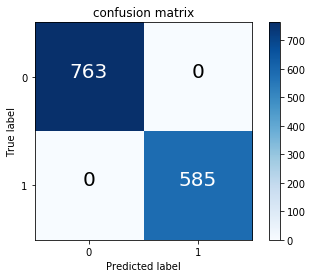

In [55]:
#first find best parameters for RandomForest before using pipeline
def best_params(X,y):
    kf = KFold(n_splits=5, shuffle = True)
    kf.get_n_splits(X)

    n_estimators = []
    for train_index, test_index in kf.split(X):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        param_grid = {'n_estimators': [100, 200, 300, 400], 'n_jobs': [-1]}

        grid = GridSearchCV(RandomForestClassifier(), 
                    param_grid, 
                    cv=3, 
                    scoring='accuracy')

        grid = grid.fit(X_train, y_train)

        print(grid.best_params_, grid.best_estimator_)
        n_estimators.append(grid.best_params_['n_estimators'])
        
    return mode(n_estimators)[0][0]

best_parameter = best_params(X,y)
print(best_parameter)

#now use pipeline
acc_test, roc_score, precision, recall, _ =  my_classifier(X,y, 'randomforest',best_parameter)

9.Support vector machines are another type of classifier. Read the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and then try implementing that one.

In [ ]:
#insert 9

10.Take in a new school's data and predict the school's profit status.

In [ ]:
#insert 10

11.What are the worst schools? Some of them are chains so don't necessarily consider singular names but generalize to chains. Give justification for your analysis.

In [ ]:
# insert 11

12.If you were a governmental organization overseeing accreditation, what factors would be most important to you in making sure that the college was non-predatory?

In [ ]:
#insert 12